# Al-Hitawi Mohammed P622VN -
Cart-Pole Controller Project

Her are the first vertion for final test you can change btween algothims by boolean value variable  (self.ddqn = False) and self.dueling = True # use dealing netowrk  else it will run DQN and if you want to change with Double DQN  for testing you can use the models that I saved them 
also change soft update boolean value btw true and false 

In [1]:
import os
import random
import gym
import pylab
import numpy as np
from collections import deque
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda, Add
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

C:\Users\Mohammed\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
C:\Users\Mohammed\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Mohammed\anaconda3\lib\site-packages\numexpr\expressions.py:21: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  _np_version_forbids_neg_powint = LooseVersion(numpy.__version__) >= LooseVersion('1.12.0b1')


# Model Architecture

In [2]:
#her we are using same model for all algorthims the only thing we need is 
# to change bool value to what we want to excute 
def All_in_OneModel(input_shape, action_space, dueling): 
    X_input = Input(input_shape)
    X = X_input
    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)
    
    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)
    if dueling:
        state_value = Dense(1, kernel_initializer='he_uniform')(X)
        state_value = Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(state_value)

        action_advantage = Dense(action_space, kernel_initializer='he_uniform')(X)
        action_advantage = Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(action_advantage)

        X = Add()([state_value, action_advantage])
    else:
        # Output Layer with # of actions: 2 nodes (left, right)
        X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs = X_input, outputs = X)
    model.compile(loss="mean_squared_error", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])

    model.summary()
    return model

In [6]:
class DQNAgent:
    def __init__(self, env_name):
        self.env_name = env_name       
        self.env = gym.make(env_name)
        self.env.seed(0)  
        # by default, CartPole-v1 has max episode steps = 500
        self.env._max_episode_steps =200  # 4000
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n

        self.EPISODES = 500  # 1000
        self.memory = deque(maxlen=2000)
        
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01 # minimum exploration probability
        self.epsilon_decay = 0.999 # exponential decay rate for exploration prob
        self.batch_size = 32 
        self.train_start = 500 # 1000

#         Dueling DQN
        # defining model parameters
        self.ddqn = False # use doudle deep q network
        self.Soft_Update = False # use soft parameter update
        self.dueling = True # use dealing netowrk

        self.TAU = 0.1 # target network soft update hyperparameter
        self.Save_Path = 'C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models'
#         self.Save_Path = 'Models'
        if not os.path.exists(self.Save_Path): os.makedirs(self.Save_Path)
        self.scores, self.episodes, self.average = [], [], []
        
        if self.ddqn:
            print("----------Double DQN--------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DDQN_"+self.env_name+".h5")
        else:
            print("-------------DQN------------")
            self.Model_name = os.path.join(self.Save_Path,"Dueling DQN_"+self.env_name+".h5")
        
        # create main model and target model
        self.model = All_in_OneModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)
        self.target_model = All_in_OneModel(input_shape=(self.state_size,), action_space = self.action_size, dueling = self.dueling)

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        if not self.Soft_Update and self.ddqn:
            self.target_model.set_weights(self.model.get_weights())
            return
        if self.Soft_Update and self.ddqn:
            q_model_theta = self.model.get_weights()
            target_model_theta = self.target_model.get_weights()
            counter = 0
            for q_weight, target_weight in zip(q_model_theta, target_model_theta):
                target_weight = target_weight * (1-self.TAU) + q_weight * self.TAU
                target_model_theta[counter] = target_weight
                counter += 1
            self.target_model.set_weights(target_model_theta)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def act(self, state):
        if np.random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            return np.argmax(self.model.predict(state))

    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, self.batch_size)

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # do this before prediction
        # for speedup, this could be done on the tensor level
        # but easier to understand using a loop
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # do batch prediction to save speed
        # predict Q-values for starting state using the main network
        target = self.model.predict(state)
        # predict best action in ending state using the main network
        target_next = self.model.predict(next_state)
        # predict Q-values for ending state using the target network
        target_val = self.target_model.predict(next_state)

        for i in range(len(minibatch)):
            # correction on the Q value for the action used
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                if self.ddqn: # Double - DQN
                    # current Q Network selects the action
                    # a'_max = argmax_a' Q(s', a')
                    a = np.argmax(target_next[i])
                    # target Q Network evaluates the action
                    # Q_max = Q_target(s', a'_max)
                    target[i][action[i]] = reward[i] + self.gamma * (target_val[i][a])   
                else: # Standard - DQN
                    # DQN chooses the max Q value among next actions
                    # selection and evaluation of action is on the target Q Network
                    # Q_max = max_a' Q_target(s', a')
                    target[i][action[i]] = reward[i] + self.gamma * (np.amax(target_next[i]))

        # Train the Neural Network with batches
        self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    pylab.figure(figsize=(18, 9))
    def PlotModel(self, score, episode):
        self.scores.append(score)
        self.episodes.append(episode)
        self.average.append(sum(self.scores[-50:]) / len(self.scores[-50:]))
        pylab.plot(self.episodes, self.average, 'r')
        pylab.plot(self.episodes, self.scores, 'b')
        pylab.ylabel('Score', fontsize=18)
        pylab.xlabel('Steps', fontsize=18)
        dqn = 'DQN_'
        softupdate = ''
        dueling = ''
        if self.ddqn: dqn = 'DDQN_'
        if self.Soft_Update: softupdate = '_soft'
        if self.dueling: dueling = '_Dueling'
        try:
            pylab.savefig(dqn+self.env_name+softupdate+dueling+".png")
        except OSError:
            pass

        return str(self.average[-1])[:5]
    
    def run(self):
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                #self.env.render()
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == self.env._max_episode_steps-1:
                    reward = reward
                else:
                    reward = -100
                self.remember(state, action, reward, next_state, done)
                state = next_state
                i += 1
                if done:
                    # every step update target model
                    self.update_target_model()
                    
                    # every episode, plot the result
                    average = self.PlotModel(i, e)
                     
                    print("episode: {}/{}, score: {}, e: {:.2}, average: {}".format(e, self.EPISODES, i, self.epsilon, average))
                    if i == self.env._max_episode_steps:
                        print("Saving trained model as", self.Model_name)
                        self.save(self.Model_name)
                        break
                self.replay()
# for testing our Model 
    def test(self):
        self.load(self.Model_name)
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.EPISODES, i))

<Figure size 1296x648 with 0 Axes>

-------------DQN------------
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_10 (Dense)               (None, 512)          2560        ['input_3[0][0]']                
                                                                                                  
 dense_11 (Dense)               (None, 256)          131328      ['dense_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 64)           16448       ['dense_11[0][0]']               
                                                               

episode: 49/500, score: 200, e: 0.027, average: 82.02
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 50/500, score: 200, e: 0.022, average: 85.7
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 51/500, score: 114, e: 0.02, average: 87.38
episode: 52/500, score: 10, e: 0.02, average: 87.24
episode: 53/500, score: 10, e: 0.02, average: 86.84
episode: 54/500, score: 10, e: 0.019, average: 86.64
episode: 55/500, score: 11, e: 0.019, average: 86.24
episode: 56/500, score: 143, e: 0.017, average: 88.22
episode: 57/500, score: 157, e: 0.014, average: 90.88
episode: 58/500, score: 11, e: 0.014, average: 90.86
episode: 59/500, score: 200, e: 0.011, average: 94.0
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 60/500, score: 200, e: 0.01, average: 97.52
Saving trained model as C:/Users/Mohammed/DRL/Proje

episode: 148/500, score: 200, e: 0.01, average: 117.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 149/500, score: 200, e: 0.01, average: 118.3
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 150/500, score: 200, e: 0.01, average: 118.3
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 151/500, score: 200, e: 0.01, average: 118.5
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 152/500, score: 185, e: 0.01, average: 118.6
episode: 153/500, score: 161, e: 0.01, average: 118.6
episode: 154/500, score: 167, e: 0.01, average: 118.5
episode: 155/500, score: 200, e: 0.01, average: 119.0
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 156/500, score: 200, e: 0.01, average: 

episode: 216/500, score: 200, e: 0.01, average: 154.4
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 217/500, score: 168, e: 0.01, average: 157.6
episode: 218/500, score: 200, e: 0.01, average: 161.4
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 219/500, score: 200, e: 0.01, average: 165.2
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 220/500, score: 200, e: 0.01, average: 169.0
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 221/500, score: 200, e: 0.01, average: 172.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 222/500, score: 173, e: 0.01, average: 176.1
episode: 223/500, score: 189, e: 0.01, average: 178.6
episode: 224/500, score: 200, e: 0.01, average: 

episode: 285/500, score: 200, e: 0.01, average: 174.5
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 286/500, score: 196, e: 0.01, average: 174.4
episode: 287/500, score: 200, e: 0.01, average: 174.4
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 288/500, score: 193, e: 0.01, average: 174.3
episode: 289/500, score: 200, e: 0.01, average: 174.3
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 290/500, score: 200, e: 0.01, average: 174.3
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 291/500, score: 200, e: 0.01, average: 174.3
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 292/500, score: 200, e: 0.01, average: 174.3
Saving trained model as C:/Users/Mohammed/DRL/Pr

episode: 353/500, score: 175, e: 0.01, average: 168.6
episode: 354/500, score: 185, e: 0.01, average: 168.3
episode: 355/500, score: 171, e: 0.01, average: 167.7
episode: 356/500, score: 136, e: 0.01, average: 166.4
episode: 357/500, score: 157, e: 0.01, average: 165.5
episode: 358/500, score: 149, e: 0.01, average: 164.5
episode: 359/500, score: 200, e: 0.01, average: 164.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 360/500, score: 200, e: 0.01, average: 164.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 361/500, score: 200, e: 0.01, average: 164.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 362/500, score: 139, e: 0.01, average: 163.6
episode: 363/500, score: 200, e: 0.01, average: 163.6
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartP

episode: 442/500, score: 189, e: 0.01, average: 179.8
episode: 443/500, score: 149, e: 0.01, average: 180.1
episode: 444/500, score: 200, e: 0.01, average: 181.1
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 445/500, score: 200, e: 0.01, average: 181.8
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 446/500, score: 200, e: 0.01, average: 183.2
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 447/500, score: 200, e: 0.01, average: 183.2
Saving trained model as C:/Users/Mohammed/DRL/Project/2opt_take/Final/Models\Dueling DQN_CartPole-v1.h5
episode: 448/500, score: 107, e: 0.01, average: 181.6
episode: 449/500, score: 12, e: 0.01, average: 177.8
episode: 450/500, score: 12, e: 0.01, average: 175.1
episode: 451/500, score: 13, e: 0.01, average: 171.4
episode: 452/500, score: 14, e: 0.01, average: 

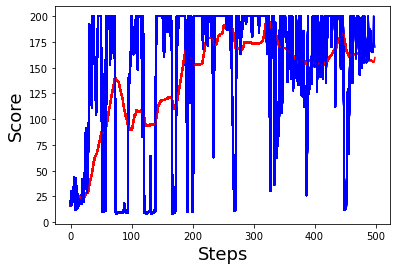

In [7]:
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
    agent.run()
    #agent.test()

Dueling DQN training with 1000 Epizode   


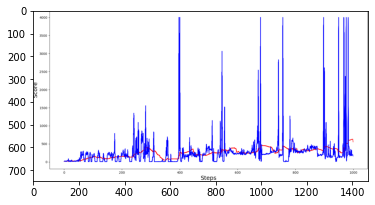

In [1]:
img = mpimg.imread('C:/Users/Mohammed/DRL/Project/2opt_take/Final/Images/DQN_CartPole-v1_DuelingWith100Eps.png')
print("Dueling DQN training with 1000 Epizode   " )
imgplot = plt.imshow(img)

Testing dueling DQN Model with 500 Eps ,important I tested befor with 1000Eps 
and 4000 steps you can see the saved models image in image folder  


In [8]:
# PATH = 'C:\Users\Mohammed\DRL\Project\2opt_take\Final\Models'
if __name__ == "__main__":
    env_name = 'CartPole-v1'
    agent = DQNAgent(env_name)
#     agent.run()
    agent.test()

-------------DQN------------
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 dense_20 (Dense)               (None, 512)          2560        ['input_5[0][0]']                
                                                                                                  
 dense_21 (Dense)               (None, 256)          131328      ['dense_20[0][0]']               
                                                                                                  
 dense_22 (Dense)               (None, 64)           16448       ['dense_21[0][0]']               
                                                               

episode: 116/500, score: 200
episode: 117/500, score: 200
episode: 118/500, score: 200
episode: 119/500, score: 200
episode: 120/500, score: 200
episode: 121/500, score: 200
episode: 122/500, score: 200
episode: 123/500, score: 200
episode: 124/500, score: 194
episode: 125/500, score: 197
episode: 126/500, score: 200
episode: 127/500, score: 192
episode: 128/500, score: 200
episode: 129/500, score: 200
episode: 130/500, score: 200
episode: 131/500, score: 200
episode: 132/500, score: 198
episode: 133/500, score: 200
episode: 134/500, score: 200
episode: 135/500, score: 200
episode: 136/500, score: 200
episode: 137/500, score: 200
episode: 138/500, score: 200
episode: 139/500, score: 195
episode: 140/500, score: 200
episode: 141/500, score: 200
episode: 142/500, score: 200
episode: 143/500, score: 200
episode: 144/500, score: 195
episode: 145/500, score: 200
episode: 146/500, score: 200
episode: 147/500, score: 200
episode: 148/500, score: 192
episode: 149/500, score: 200
episode: 150/5

episode: 399/500, score: 196
episode: 400/500, score: 197
episode: 401/500, score: 200
episode: 402/500, score: 185
episode: 403/500, score: 200
episode: 404/500, score: 200
episode: 405/500, score: 200
episode: 406/500, score: 200
episode: 407/500, score: 200
episode: 408/500, score: 200
episode: 409/500, score: 200
episode: 410/500, score: 200
episode: 411/500, score: 200
episode: 412/500, score: 200
episode: 413/500, score: 200
episode: 414/500, score: 189
episode: 415/500, score: 200
episode: 416/500, score: 200
episode: 417/500, score: 188
episode: 418/500, score: 200
episode: 419/500, score: 200
episode: 420/500, score: 200
episode: 421/500, score: 200
episode: 422/500, score: 197
episode: 423/500, score: 200
episode: 424/500, score: 200
episode: 425/500, score: 200
episode: 426/500, score: 200
episode: 427/500, score: 194
episode: 428/500, score: 200
episode: 429/500, score: 200
episode: 430/500, score: 197
episode: 431/500, score: 200
episode: 432/500, score: 200
episode: 433/5